<a href="https://colab.research.google.com/github/Ke-erah/Cousera_Capstone/blob/master/More_on_Handling_Missing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Introduction**

In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving nypd_mvc_2018.csv to nypd_mvc_2018 (1).csv


In [4]:
import io
mvc = pd.read_csv(io.BytesIO(uploaded['nypd_mvc_2018.csv']))
mvc.head()

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,0,0.0,0,0,0,0.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,0,0.0,0,0,0,0.0,SPORT UTILITY / STATION WAGON,DS,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,3914294,2018-06-04,0:00,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,1,1.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,0,0.0,0,0,0,0.0,Sedan,Sedan,NaN,NaN,NaN,Glare,Passing Too Closely,NaN,NaN,NaN
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,0,0.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN


Data can be missing for a variety of reasons.

In this mission, we'll learn how to handle missing data without having to drop rows and columns using data on motor vehicle collisions released by New York City and published on the NYC OpenData website. There is data on over 1.5 million collisions dating back to 2012, with additional data continuously added.

We'll work with an extract of the full data: Crashes from the year 2018. We made several modifications to the data for teaching purposes, including randomly sampling the data to reduce its size. You can download the data set from this mission by using the data set preview tool at the top of the "script.py" codebox on the right.

Next, we can use the DataFrame.isnull() method to identify which values are null



In [5]:
null_counts = mvc.isnull().sum() 
null_counts

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64

# **Verifying Total Columns**

To give us a better picture of the null values in the data, let's calculate the percentage of null values in each column. Below, we divide the number of null values in each column by the total number of values in the data set.



In [6]:
null_counts_pct = null_counts / mvc.shape[0] * 100
null_counts_pct

unique_key              0.000000
date                    0.000000
time                    0.000000
borough                35.680216
location                6.714019
on_street              24.127264
cross_street           50.547836
off_street             76.201092
pedestrians_injured     0.000000
cyclist_injured         0.000000
motorist_injured        0.000000
total_injured           0.001728
pedestrians_killed      0.000000
cyclist_killed          0.000000
motorist_killed         0.000000
total_killed            0.008641
vehicle_1               0.613508
vehicle_2              21.191069
vehicle_3              93.930596
vehicle_4              98.779898
vehicle_5              99.683741
cause_vehicle_1         0.302433
cause_vehicle_2        15.021430
cause_vehicle_3        93.553850
cause_vehicle_4        98.698673
cause_vehicle_5        99.666459
dtype: float64

We'll then add both the counts and percentages to a dataframe to make them easier to compare:

In [7]:
null_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})
# Rotate the dataframe so that rows become columns and vice-versa
null_df = null_df.T.astype(int)

print(null_df)

             unique_key  date  ...  cause_vehicle_4  cause_vehicle_5
null_counts           0     0  ...            57111            57671
null_pct              0     0  ...               98               99

[2 rows x 26 columns]


About a third of the columns have no null values, with the rest ranging from less than 1% to 99%!

To make things easier, let's start by looking at the group of columns that relate to people killed in collisions.

We'll use list comprehension to reduce our summary dataframe to just those columns:

In [50]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
null_df[killed_cols]

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
null_counts,0,0,0,5
null_pct,0,0,0,0


We can see that each of the individual categories have no missing values, but the total_killed column has five missing values.

One option for handling this would be to remove – or drop – those five rows. This would be a reasonably valid choice since it's a tiny portion of the data, but let's think about what other options we have first.

If you think about it, the total number of people killed should be the sum of each of the individual categories. We might be able to "fill in" the missing values with the sums of the individual columns for that row. The technical name for filling in a missing value with a replacement value is called imputation.

Let's look at how we could explore the values where the total_killed isn't equal to the sum of the other three columns. We'll illustrate this process using a series of diagrams. The diagrams won't contain values, they'll just show a grid to represent the values.

In [0]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum = killed.iloc[:,0:3].sum(axis=1)

killed_mask = killed_manual_sum != killed['total_killed']

killed_non_eq = killed[killed_mask]

In [10]:
killed_non_eq

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


# **Filling and Verifying the Killed and Injured Data**

We can categorize these into two categories:

Five rows where the total_killed is not equal to the sum of the other columns because the total value is missing.
One row where the total_killed is less than the sum of the other columns.
From this, we can conclude that filling null values with the sum of the columns is a fairly good choice for our imputation, given that only six rows out of around 58,000 don't match this pattern.

We've also identified a row that has suspicious data - one that doesn't sum correctly. Once we have imputed values for all rows with missing values for total_killed, we'll mark this suspect row by setting its value to NaN.

In order to execute this, we'll learn to use the Series.mask() method. Series.mask() is useful when you want to replace certain values in a series based off a boolean mask. 

Let's look at how we'd use this technique to update the values in the total_killed column. First, we'll replace all null values with the equivalent values from our killed_manual_sum series:


In [0]:
killed_null = killed['total_killed'].isnull()
killed['total_killed'] = killed['total_killed'].mask(killed_null, killed_manual_sum)

Next, we'll replace any values where the manual sum and the total column aren't equal with np.nan. This time we'll define the boolean series directly into Series.mask():

In [0]:
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

Now let's look at the values we've changed:


In [51]:
killed[killed_mask]

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,0.0
20163,0,0,0,0.0
22046,0,0,1,1.0
48719,0,0,0,0.0
55148,0,0,0,0.0
55699,0,0,0,0.0


We've gone from five null values to one, and flagged some suspicious data. Let's do the same for the injured columns.

In [0]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

In [0]:
# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)

injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

In [16]:
injured

,pedestrians_injured,cyclist_injured,motorist_injured,total_injured
0,0,0,0,0.0
1,0,0,0,0.0
2,0,0,1,1.0
3,0,0,0,0.0
4,0,0,0,0.0
...,...,...,...,...
57859,3,0,0,3.0
57860,0,0,0,0.0
57861,0,0,1,1.0
57862,0,0,0,0.0


# **Assigning the Corrected Data Back to the Main Dataframe**

Let's summarize the count of null values before and after our changes:

In [17]:
null_counts_pct = null_counts / mvc.shape[0] * 100
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=['before','after']))

        injured  killed
before        1       5
after        21       0


For the total_killed column, the number of values has gone down from 5 to 1. For the total_injured column, the number of values has actually gone up — from 1 to 21. This might sound like we've done the opposite of what we set out to do, but what we've actually done is fill all the null values and identify values that have suspect data. This will make any analysis we do on this data more accurate in the long run.

Let's assign the values from the killed and injured dataframe back to the main mvc dataframe.

In [18]:
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']
mvc

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,0,0.0,0,0,0,0.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,0,0.0,0,0,0,0.0,SPORT UTILITY / STATION WAGON,DS,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,3914294,2018-06-04,0:00,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,1,1.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,0,0.0,0,0,0,0.0,Sedan,Sedan,NaN,NaN,NaN,Glare,Passing Too Closely,NaN,NaN,NaN
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,0,0.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57859,3835191,2018-01-26,14:51,BRONX,"(40.85477, -73.90299)",CRESTON AVENUE,EAST 181 STREET,NaN,3,0,0,3.0,0,0,0,0.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Unspecified,NaN,NaN,NaN,NaN
57860,3890674,2018-04-29,18:30,QUEENS,"(40.78419, -73.84582)",COLLEGE POINT BOULEVARD,15 AVENUE,NaN,0,0,0,0.0,0,0,0,0.0,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
57861,3946458,2018-07-21,16:45,NaN,"(40.711926, -74.0061)",PARK ROW,NaN,NaN,0,0,1,1.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN
57862,3914574,2018-06-04,5:45,NaN,"(40.71976, -73.94476)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,0,0,0,0.0,0,0,0,0.0,Sedan,Tractor Truck Diesel,Station Wagon/Sport Utility Vehicle,NaN,NaN,Other Vehicular,Unspecified,Unspecified,NaN,NaN


# **Visualizing Missing Data with Plots**

Earlier, we used a table of numbers to understand the number of missing values in our dataframe. A different approach we can take is to use a plot to visualize the missing values. The function below uses seaborn.heatmap() to represent null values as light squares and non-null values as dark squares

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
null_counts_pct = null_counts / mvc.shape[0] * 100
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

Let's look at how the function works by using it to plot just the first row of our mvc dataframe. We'll display the first row as a table immediately below so it's easy to compare:

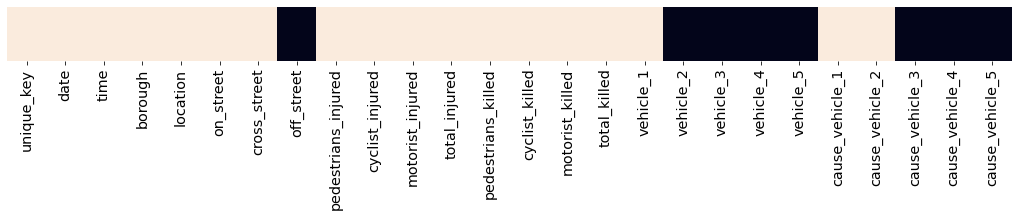

In [21]:
plot_null_matrix(mvc.head(1), figsize=(18,1))

In [22]:
mvc.head(1)

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,0,0.0,0,0,0,0.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN


Each value is represented by a dark square, and each missing value is represented by a light square.

Let's look at what a plot matrix looks like for the whole dataframe.

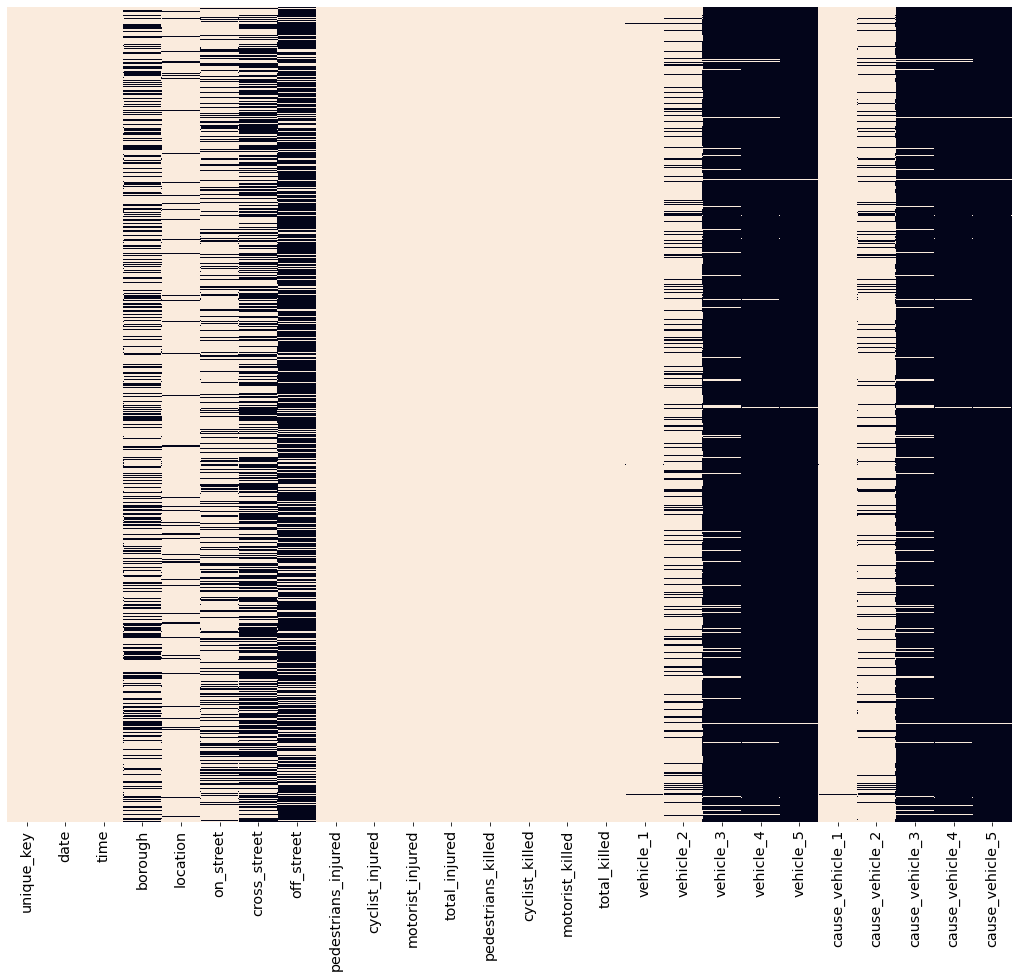

In [23]:
plot_null_matrix(mvc)

We can make some immediate interpretations about our dataframe:

The first three columns have few to no missing values.
The next five columns have missing values scattered throughout, with each column seeming to have its own density of missing values.
The next eight columns are the injury and killed columns we just cleaned, and only have a few missing values.
The last 10 columns seem to break into two groups of five, with each group of five having similar patterns of null/non-null values.
Let's examine the pattern in the last 10 columns a little more closely. We can calculate the relationship between two sets of columns, known as correlation. To calculate this we use the dataframe.corr() method (You'll learn more about correlation in a later course). Here's what that looks like:

In [24]:
cols_with_missing_vals = mvc.columns[mvc.isnull().sum() > 0]
missing_corr = mvc[cols_with_missing_vals].isnull().corr()
missing_corr

,borough,location,on_street,cross_street,off_street,total_injured,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
borough,1.000000,0.190105,-0.350190,0.409107,0.362189,-0.002827,-0.018325,-0.077516,-0.061932,-0.020406,-0.010733,-0.012115,-0.058596,-0.060542,-0.020158,-0.011348
location,0.190105,1.000000,-0.073975,-0.069719,0.084579,-0.001486,-0.010466,-0.033842,-0.000927,0.004655,-0.005797,-0.003458,-0.021373,0.000684,0.004604,-0.004841
on_street,-0.350190,-0.073975,1.000000,0.557767,-0.991030,0.006220,-0.001889,0.119647,0.020867,0.004172,-0.002768,0.001307,0.087374,0.017426,0.002737,-0.003107
cross_street,0.409107,-0.069719,0.557767,1.000000,-0.552763,0.002513,-0.017018,0.043799,-0.049910,-0.021137,-0.012003,-0.009102,0.031189,-0.052159,-0.022074,-0.013455
off_street,0.362189,0.084579,-0.991030,-0.552763,1.000000,-0.004266,0.001812,-0.121129,-0.022404,-0.004074,0.002492,-0.001738,-0.088187,-0.019120,-0.002580,0.002863
total_injured,-0.002827,-0.001486,0.006220,0.002513,-0.004266,1.000000,0.079840,0.025644,-0.002757,0.002118,0.001073,0.131140,0.030082,-0.002388,0.002188,0.001102
vehicle_1,-0.018325,-0.010466,-0.001889,-0.017018,0.001812,0.079840,1.000000,0.151516,0.019972,0.008732,0.004425,0.604281,0.180678,0.020624,0.009022,0.004545
vehicle_2,-0.077516,-0.033842,0.119647,0.043799,-0.121129,0.025644,0.151516,1.000000,0.131813,0.057631,0.029208,0.106214,0.784402,0.132499,0.058050,0.029264
vehicle_3,-0.061932,-0.000927,0.020867,-0.049910,-0.022404,-0.002757,0.019972,0.131813,1.000000,0.437214,0.221585,0.014000,0.106874,0.961316,0.448525,0.225067
vehicle_4,-0.020406,0.004655,0.004172,-0.021137,-0.004074,0.002118,0.008732,0.057631,0.437214,1.000000,0.506810,0.006121,0.046727,0.423394,0.963723,0.515058


Each value is between  and , and represents the relationship between two columns. A number close to  or  represents a strong relationship, where a number in the middle (close to ) represents a weak relationship.

If you look closely, you can see a diagonal line of s going from top left to bottom right. These values represent each columns relationship with itself, which of course is a perfect relationship. The values on the top/right of this "line of s" mirror the values on the bottom/left of this line: The table actually repeats every value twice!

Correlation tables can be hard to interpret. We can convert our table into a plot which will make this a lot easier. Let's see what this plot looks like:

We provided a helper function to create correlation plots. Let's create a correlation plot of just those last 10 columns to see if we can more closely identify the pattern we saw earlier in the matrix plot.

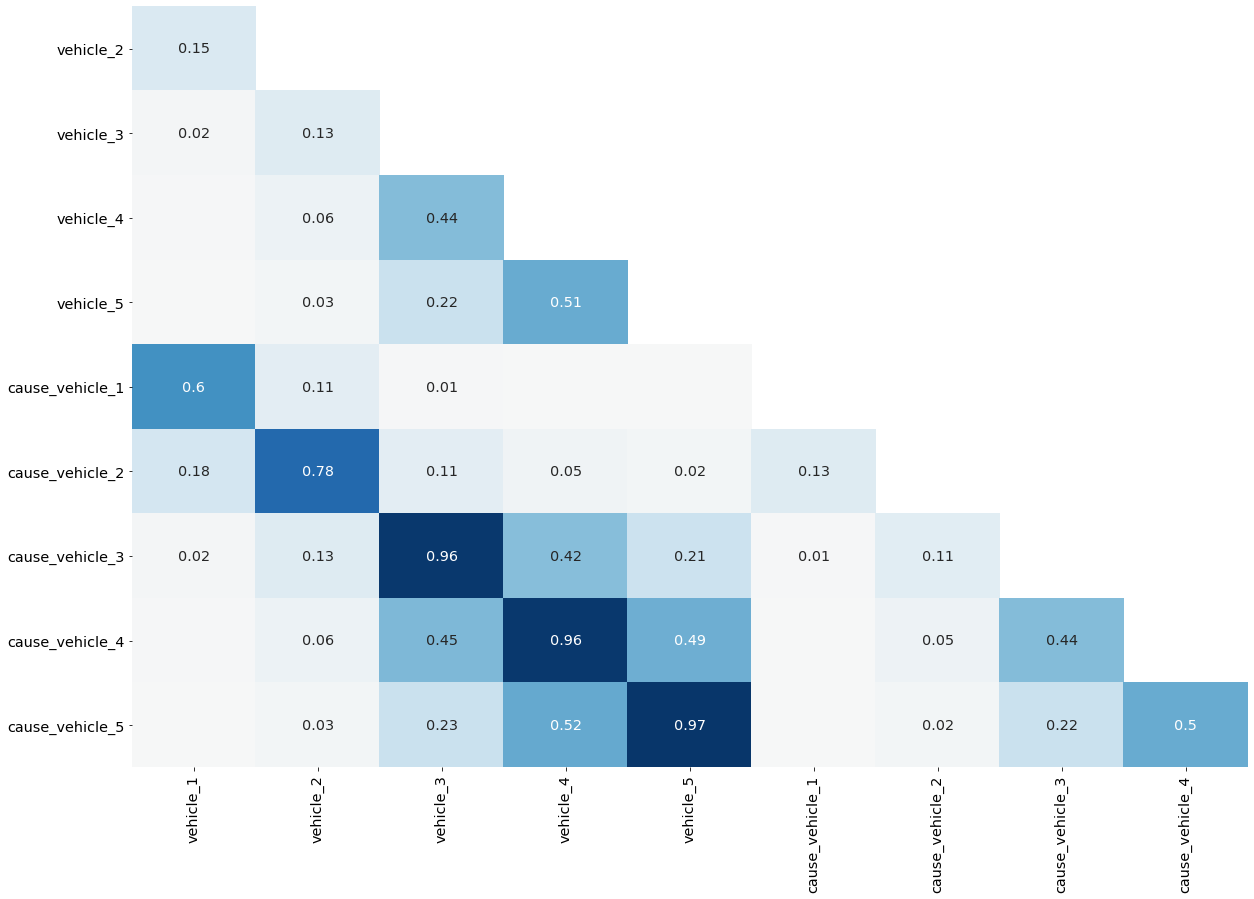

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
veh_cols = [cols for cols in mvc.columns if 'vehicle' in cols]

vehicle_columns = mvc[veh_cols]

plot_null_correlations(vehicle_columns)

# **Analyzing Correlation in Missing Data**

We outlined a diagonal strip of five squares in green that have a higher correlation than the rest. The pairs of column names that make up these five correlations are:

1. vehicle_1 and cause_vehicle_1
2. vehicle_2 and cause_vehicle_2
3. vehicle_3 and cause_vehicle_3
4. vehicle_4 and cause_vehicle_4
5. vehicle_5 and cause_vehicle_5

If you think about it, this makes sense. When a vehicle is in an accident, there is likely to be a cause, and vice-versa.

Let's explore the variations in missing values from these five pairs of columns. We'll create a dataframe that counts, for each pair:

The number of values where the vehicle is missing when the cause is not missing.
The number of values where the cause is missing when the vehicle is not missing.

In [0]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    rows = [v, v_null, c_null]
    vc_null_data.append(rows)
    
vc_null_df = pd.DataFrame(vc_null_data, columns = col_labels)

In [27]:
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


# **Finding the Most Common Values Across Multiple Columns**

The analysis we did on the previous screen indicates that there are roughly 4,500 missing values across the 10 columns. The easiest option for handling these would be to drop the rows with missing values. This would mean losing almost 10% of the total data, which is something we ideally want to avoid.

A better option is to impute the data, like we did earlier. Because the data in these columns is text data, we can't perform a numeric calculation to impute missing data like we did with the injuries and killed columns.

One common option when imputing is to use the most common value to fill in data. Let's look at the common values across these columns and see if we can use that to make a decision.

We've previously used the Series.value_counts() method to find the most common values in a single column. In this case, we want to find the most common values across multiple columns. In order to do this, we first need to convert our dataframe of multiple columns into one single column, and then we can use Series.value_counts() to count the items.

To convert a dataframe to a single column of values, we use the DataFrame.stack() method, which stacks a dataframe object into a Series object.

Once we have this stacked series, we can just use Series.value_counts() to count the values:

Let's use this technique to count the most common values for the cause set of columns. We'll start by selecting only the columns containing the substring cause.

In [28]:
cause_cols = [c for c in mvc.columns if "cause_" in c]
cause = mvc[cause_cols]
cause.head()

,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,Following Too Closely,Unspecified,NaN,NaN,NaN
1,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,Following Too Closely,Unspecified,NaN,NaN,NaN
3,Glare,Passing Too Closely,NaN,NaN,NaN
4,Turning Improperly,Unspecified,NaN,NaN,NaN


In [29]:
#Next, we'll stack the values into a single series object:

cause_1d = cause.stack()
cause_1d.head()

0  cause_vehicle_1    Following Too Closely
   cause_vehicle_2              Unspecified
1  cause_vehicle_1         Backing Unsafely
   cause_vehicle_2              Unspecified
2  cause_vehicle_1    Following Too Closely
dtype: object

You may notice that the stacked version omits null values - this is fine, as we're just interested in the most common non-null values.

In [30]:
#Finally, we count the values in the series:

cause_counts = cause_1d.value_counts()
top10_causes = cause_counts.head(10)
top10_causes

Unspecified                       57481
Driver Inattention/Distraction    17650
Following Too Closely              6567
Failure to Yield Right-of-Way      4566
Passing or Lane Usage Improper     3260
Passing Too Closely                3045
Backing Unsafely                   3001
Other Vehicular                    2523
Unsafe Lane Changing               2372
Turning Improperly                 1590
dtype: int64

The most common non-null value for the cause columns is Unspecified, which presumably indicates that the officer reporting the collision was unable to determine the cause for that vehicle.

Let's use the same technique to identify the most common non-null value for the vehicle columns.

In [31]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

vehicle_df = mvc[v_cols]

vehicles_1d = vehicle_df.stack()

top10_vehicles = vehicles_1d.value_counts().head(10)
top10_vehicles

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
Pick-up Truck                           2373
TAXI                                    1892
Box Truck                               1659
Bike                                    1190
Bus                                     1162
dtype: int64

# **Filling Unknown Values with a Placeholder**

In [32]:
top10_causes

Unspecified                       57481
Driver Inattention/Distraction    17650
Following Too Closely              6567
Failure to Yield Right-of-Way      4566
Passing or Lane Usage Improper     3260
Passing Too Closely                3045
Backing Unsafely                   3001
Other Vehicular                    2523
Unsafe Lane Changing               2372
Turning Improperly                 1590
dtype: int64

The top "cause" is an "Unspecified" placeholder. This is useful instead of a null value as it makes the distinction between a value that is missing because there were only a certain number of vehicles in the collision versus one that is because the contributing cause for a particular vehicle is unknown.

The vehicles columns don't have an equivalent, but we can still use the same technique. Here's the logic we'll need to do for each pair of vehicle/cause columns:

For values where the vehicle is null and the cause is non-null, set the vehicle to Unspecified.
For values where the cause is null and the vehicle is not-null, set the cause to Unspecified.
We can use Series.mask() to replace the values, just like we did earlier in the mission. Let's look at code to perform this for the vehicle_1 and vehicle_cause_1 columns:

In [33]:
# create a mask for each column
v_missing_mask = mvc['vehicle_1'].isnull() & mvc['cause_vehicle_1'].notnull()
c_missing_mask = mvc['cause_vehicle_1'].isnull() & mvc['vehicle_1'].notnull()

# replace the values matching the mask for each column
mvc['vehicle_1'] =  mvc['vehicle_1'].mask(v_missing_mask, "Unspecified")
mvc['cause_vehicle_1'] =  mvc['cause_vehicle_1'].mask(c_missing_mask, "Unspecified")
mvc.head()

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,0,0.0,0,0,0,0.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,0,0.0,0,0,0,0.0,SPORT UTILITY / STATION WAGON,DS,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,3914294,2018-06-04,0:00,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,1,1.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,0,0.0,0,0,0,0.0,Sedan,Sedan,NaN,NaN,NaN,Glare,Passing Too Closely,NaN,NaN,NaN
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,0,0.0,0,0,0,0.0,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN


Now let's use a loop to fill in these values across all columns. We've created a helper function summarize_missing() which contains the logic we used earlier to count missing values across the pairs of columns. Below is a quick demonstration on how it works:

In [0]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

In [35]:
summarize_missing()

,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


In [0]:
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull())
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull())
    
    mvc[v_col]=mvc[v_col].mask(v_null, 'Unspecified')
    mvc[c_col]= mvc[c_col].mask(c_null, 'Unspecified')
    
summary_after = summarize_missing()

In [39]:
summary_after

,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


# **Missing Data in "Location" Columns**

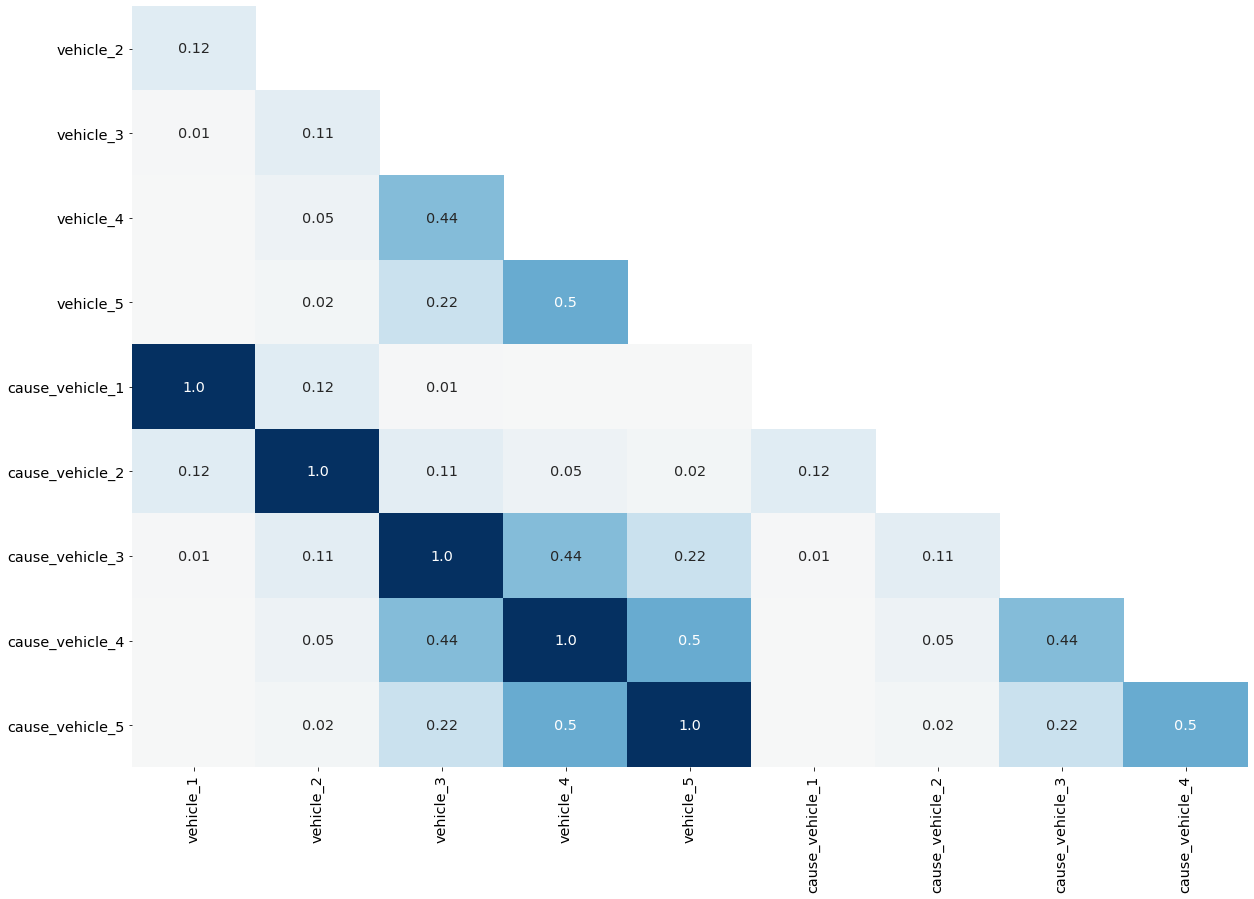

In [40]:
#Let's view the work we've done across the past few screens by looking at the null correlation plot for the last 10 columns:
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

You can see the perfect correlation between each pair of vehicle/cause columns represented by  in each square, which means that there is a perfect relationship between the five pairs of vehicle/cause columns.

Let's now turn our focus to the final set of columns that contain missing values — the columns that relate to the location of the accident. We'll start by looking at the first few rows to refamiliarize ourselves with the data:

In [41]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]
location_data.head()

,borough,location,on_street,off_street,cross_street
0,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,NaN,10 AVENUE
1,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,NaN,62 STREET
2,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN
3,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,NaN,VANLOON STREET
4,BRONX,"(40.884727, -73.89945)",NaN,208 WEST 238 STREET,NaN


Next, let's look at counts of the null values in each column:



In [42]:
location_data.isnull().sum()

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64

These columns have a lot of missing values! Keep in mind that all of these five columns represent the same thing — the location of the collision. We can potentially use the non-null values to impute some of the null values.

To see where we might be able to do this, let's look for correlations between the missing values:

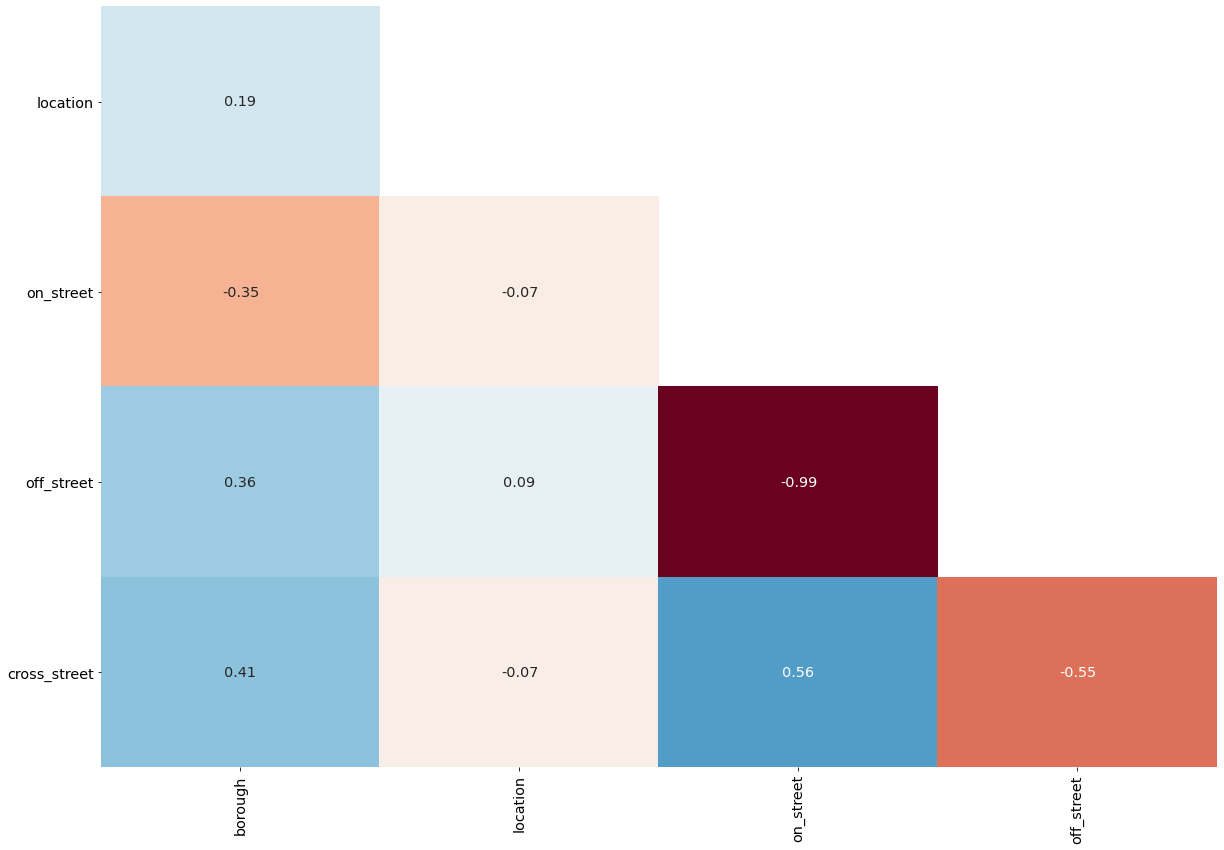

In [43]:
plot_null_correlations(location_data)

None of these columns have strong correlations except for off_street and on_street which have a near perfect negative correlation. That means for almost every row that has a null value in one column, the other has a non-null value and vice-versa.

The final way we'll look at the null values in these columns is to plot a null matrix, but we'll sort the data first. This will gather some of the null and non-null values together and make patterns more obvious:

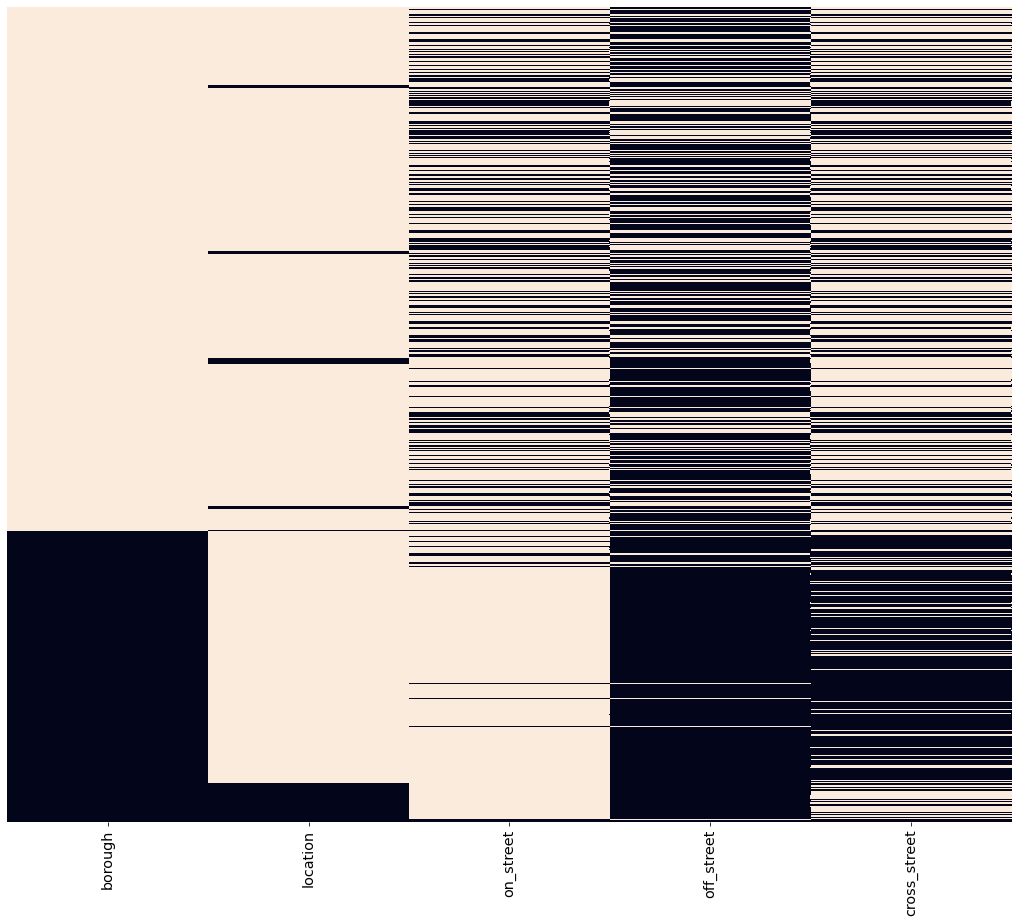

In [44]:
sorted_location_data = location_data.sort_values(loc_cols)
plot_null_matrix(sorted_location_data)

Let's make some observations about the missing values across these columns:

About two-thirds of rows have non-null values for borough, but of those values that are missing, most have non-null values for location and one or more of the street name columns.
Less than one-tenth of rows have missing values in the location column, but most of these have non-null values in one or more of the street name columns.
Most rows have a non-null value for either on_street or off_street, and some also have a value for cross_street.
Combined, this means that we will be able to impute a lot of the missing values by using the other columns in each row. To do this, we can use geolocation APIs that take either an address or location coordinates, and return information about that location.

Because the focus of this mission is working with missing data, we have pre-prepared supplemental data using APIs. On the next screen, we'll learn more about how that data was prepared and then use it to fill in missing values.

# **Imputing Location Data**

We prepared the supplemental data using the GeoPy package, which makes working with Geocoding APIs like the Google Maps API easier. Here's the strategy we used to prepare the supplemental data:

For rows with location values but missing values in either borough or the street name columns, we used geocoding APIs to look up the location coordinates to find the missing data.
For rows with values in the street name columns missing borough and/or location data, we used geocoding APIs to look up the address to find the missing data.
You can learn more about working with APIs in our APIs and Web Scraping course.

The supplemental data is in a CSV called supplemental_data.csv, let's read this into a pandas dataframe and familiarize ourself with the data:

In [45]:
uploaded = files.upload()

Saving supplemental_data.csv to supplemental_data.csv


In [46]:
sup_data = pd.read_csv('supplemental_data.csv')
sup_data.head()

,unique_key,location,on_street,off_street,borough
0,3869058,NaN,NaN,NaN,NaN
1,3847947,NaN,NaN,NaN,NaN
2,3914294,NaN,BELT PARKWAY,NaN,BROOKLYN
3,3915069,NaN,NaN,NaN,NaN
4,3923123,NaN,NaN,NaN,NaN


The supplemental data has five columns from our original data set — the unique_key that identifies each collision, and four of the five location columns. The cross_street column is not included because the geocoding APIs we used don't include data on the nearest cross street to any single location.

Let's take a look at a null matrix for the supplemental data:

In [0]:
plot_null_matrix(sup_data)

Apart from the unique_key column, you'll notice that there are a lot more missing values than our main data set. This makes sense, as we didn't prepare supplemental data where the original data set had non-null values.

If the unique_key column in both the original and supplemental data has the same values in the same order, we'll be able to use Series.mask() to add our supplemental data to our original data. We can check this using the Series.equals() method:

In [48]:
mvc_keys = mvc['unique_key']
sup_keys = sup_data['unique_key']

is_equal = mvc_keys.equals(sup_keys)
is_equal

True

Now that we've verified the data, it's time to use it to impute missing values.

In [0]:
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()

for col_name in location_cols:
    mvc[col_name] = mvc[col_name].mask(mvc[col_name].isnull(), sup_data[col_name])
    
null_after = mvc[location_cols].isnull().sum()